In [1]:
# 1. Install PySpark
!pip install pyspark

# 2. Initialize a Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC Taxi Big Data Analysis") \
    .getOrCreate()

print("Spark session created successfully!")

# 3. Download the dataset using wget
# This downloads the Parquet file for Jan 2023 Yellow Taxi trips
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet

print("\nDataset downloaded successfully!")

# 4. Load the dataset into a Spark DataFrame
# Spark can read Parquet files efficiently
df = spark.read.parquet("yellow_tripdata_2023-01.parquet")

print("\nDataset loaded into Spark DataFrame.")

# 5. Perform initial exploration
print("\nHere is the schema of our dataset:")
df.printSchema()

print("\nAnd here are the first 5 rows:")
df.show(5)

Spark session created successfully!
--2025-10-04 06:51:01--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.167.84.86, 3.167.84.228, 3.167.84.131, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.167.84.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M   101MB/s    in 0.4s    

2025-10-04 06:51:02 (101 MB/s) - ‘yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]


Dataset downloaded successfully!

Dataset loaded into Spark DataFrame.

Here is the schema of our dataset:
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nulla

In [2]:
from pyspark.sql.functions import col

# Let's get some descriptive statistics for the numerical columns
print("Summary statistics for the dataset:")
df.select("passenger_count", "trip_distance", "fare_amount", "total_amount").describe().show()

# --- Data Cleaning ---

# Count the total number of records before cleaning
initial_count = df.count()
print(f"Total number of records initially: {initial_count}")

# Filter out rows with illogical data
# We will only keep trips with:
# - At least one passenger
# - A trip distance greater than 0
# - A fare amount greater than 0
df_cleaned = df.filter(
    (col("passenger_count") > 0) &
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0)
)

# Count the number of records after cleaning
cleaned_count = df_cleaned.count()
print(f"Total number of records after cleaning: {cleaned_count}")
print(f"Number of records removed: {initial_count - cleaned_count}")

# Show a sample of the cleaned data
print("\nSample of the cleaned data:")
df_cleaned.show(5)

Summary statistics for the dataset:
+-------+------------------+------------------+------------------+------------------+
|summary|   passenger_count|     trip_distance|       fare_amount|      total_amount|
+-------+------------------+------------------+------------------+------------------+
|  count|           2995023|           3066766|           3066766|           3066766|
|   mean|1.3625321074328978|3.8473420306601414| 18.36706861234247| 27.02038310708492|
| stddev|0.8961199745510026|249.58375606858166|17.807821939337924|22.163588952492184|
|    min|               0.0|               0.0|            -900.0|            -751.0|
|    max|               9.0|         258928.15|            1160.1|            1169.4|
+-------+------------------+------------------+------------------+------------------+

Total number of records initially: 3066766
Total number of records after cleaning: 2884228
Number of records removed: 182538

Sample of the cleaned data:
+--------+--------------------+----

In [3]:
from pyspark.sql.functions import count, desc

# Group by payment_type and count the occurrences
payment_counts = df_cleaned.groupBy("payment_type").agg(count("*").alias("trip_count"))

# Sort the results in descending order to see the most popular first
popular_payments = payment_counts.orderBy(desc("trip_count"))

print("Popularity of Payment Types:")
popular_payments.show()

Popularity of Payment Types:
+------------+----------+
|payment_type|trip_count|
+------------+----------+
|           1|   2350772|
|           2|    507944|
|           4|     16306|
|           3|      9206|
+------------+----------+



In [4]:
from pyspark.sql.functions import hour

# Extract the hour from the pickup timestamp and create a new column 'hour'
df_with_hour = df_cleaned.withColumn("hour", hour("tpep_pickup_datetime"))

# Group by the new 'hour' column and count the trips
hourly_counts = df_with_hour.groupBy("hour").agg(count("*").alias("trip_count"))

# Sort by hour for a chronological view
busy_hours = hourly_counts.orderBy("hour")

print("Number of Taxi Trips per Hour:")
busy_hours.show(24) # Show all 24 hours

Number of Taxi Trips per Hour:
+----+----------+
|hour|trip_count|
+----+----------+
|   0|     79567|
|   1|     55565|
|   2|     38731|
|   3|     25053|
|   4|     15836|
|   5|     16142|
|   6|     39945|
|   7|     79552|
|   8|    107901|
|   9|    122644|
|  10|    135285|
|  11|    145262|
|  12|    160233|
|  13|    168768|
|  14|    181035|
|  15|    185460|
|  16|    184673|
|  17|    197226|
|  18|    203607|
|  19|    182683|
|  20|    157380|
|  21|    153387|
|  22|    139955|
|  23|    108338|
+----+----------+



In [5]:
from pyspark.sql.functions import avg

# Group by passenger_count and calculate the average fare_amount
avg_fare_by_passengers = df_cleaned.groupBy("passenger_count").agg(
    avg("fare_amount").alias("average_fare")
)

# Sort by passenger count
fare_by_passengers_sorted = avg_fare_by_passengers.orderBy("passenger_count")

print("Average Fare by Number of Passengers:")
fare_by_passengers_sorted.show()

Average Fare by Number of Passengers:
+---------------+------------------+
|passenger_count|      average_fare|
+---------------+------------------+
|            1.0|18.074408467255598|
|            2.0| 20.40332980243411|
|            3.0| 19.86253246753282|
|            4.0|20.882765446795513|
|            5.0| 17.96817410966637|
|            6.0|18.043596657262192|
|            7.0|              67.8|
|            8.0| 82.49571428571429|
+---------------+------------------+



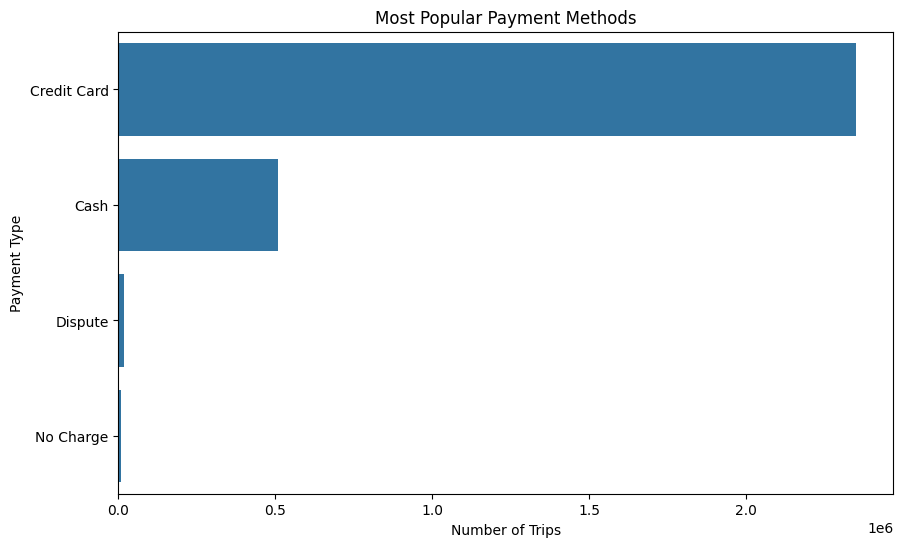

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame for payment counts to a Pandas DataFrame
payment_pd = popular_payments.toPandas()

# Define more readable labels for the payment types
payment_map = {1: 'Credit Card', 2: 'Cash', 3: 'No Charge', 4: 'Dispute', 5: 'Unknown', 6: 'Voided Trip'}
payment_pd['payment_type_label'] = payment_pd['payment_type'].map(payment_map)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='trip_count', y='payment_type_label', data=payment_pd, orient='h')
plt.title('Most Popular Payment Methods')
plt.xlabel('Number of Trips')
plt.ylabel('Payment Type')
plt.show()

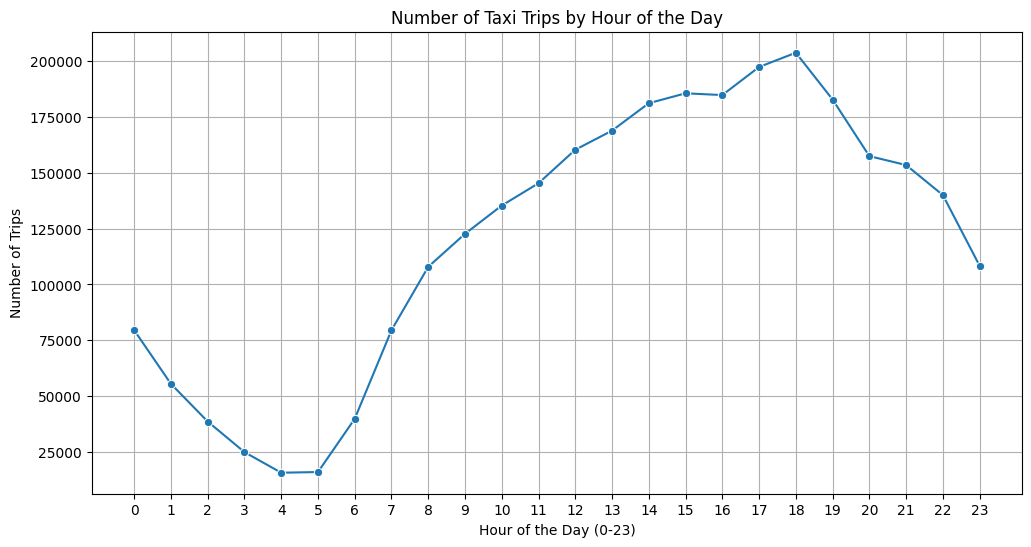

In [7]:
# Convert the Spark DataFrame for hourly counts to a Pandas DataFrame
hourly_pd = busy_hours.toPandas()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='trip_count', data=hourly_pd, marker='o')
plt.title('Number of Taxi Trips by Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Trips')
plt.xticks(range(24)) # Ensure all hours are shown on the x-axis
plt.grid(True)
plt.show()

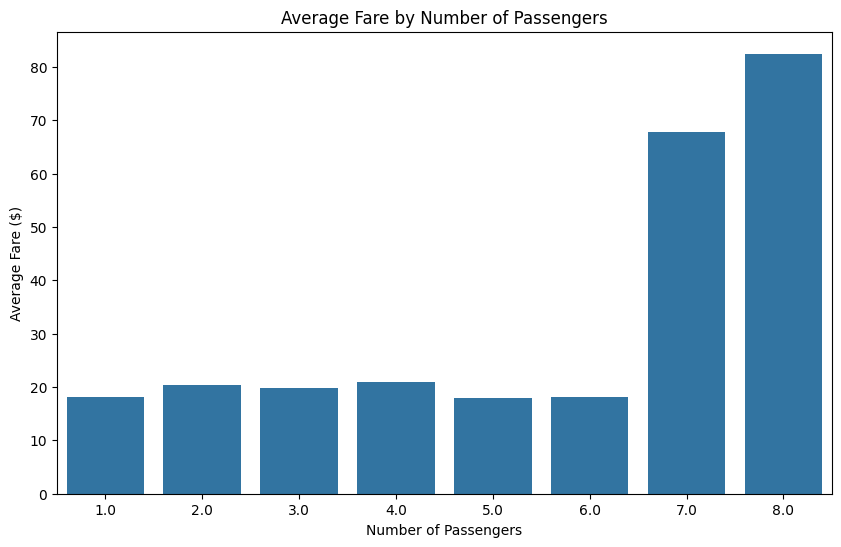

In [8]:
# Convert the Spark DataFrame to a Pandas DataFrame
fare_by_passengers_pd = fare_by_passengers_sorted.toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='passenger_count', y='average_fare', data=fare_by_passengers_pd)
plt.title('Average Fare by Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare ($)')
plt.show()